In [293]:
import numpy as np
import pandas as pd
import urllib3 as urllib
import urllib.request
import geopandas as gpd
import os
import choroplethNYC as cp
import requests
import io
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import scipy.stats
import numpy as np
import pylab as pl
from io import BytesIO as io
from urllib.parse import urlencode as urlencode
from urllib.request import urlopen as urlopen
from urllib.error import HTTPError as HTTPError
import statsmodels.formula.api as smf
import statsmodels.api as smm


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    puidata = os.getenv("PUIDATA")

# 1. Download and clean data

## 1.0. Puma data

In [60]:
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile"
urllib.request.urlretrieve(url, "file.gz")
!unzip -d $PUIDATA file.gz

Archive:  file.gz
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/geo_export_c22f6838-ef20-4c67-beca-eed24d00c9cf.dbf  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/geo_export_c22f6838-ef20-4c67-beca-eed24d00c9cf.shp  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/geo_export_c22f6838-ef20-4c67-beca-eed24d00c9cf.shx  
  inflating: /Users/anaemendezmendez/Documents/NYU_PHD/Fall_2018/PUI2018/PUIDATA/geo_export_c22f6838-ef20-4c67-beca-eed24d00c9cf.prj  


In [62]:
pumas = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + 
                "/geo_export_c22f6838-ef20-4c67-beca-eed24d00c9cf.shp")

In [63]:
pumas.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


## 1.1. Noise complaints data

In [3]:
!curl https://data.cityofnewyork.us/api/views/p5f6-bkga/rows.csv?accessType=DOWNLOAD > noise_complaints.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1555M    0 1555M    0     0  3769k      0 --:--:--  0:07:02 --:--:-- 3302k     0  3410k      0 --:--:--  0:00:26 --:--:-- 4105k:30 --:--:-- 4149k    0     0  3618k      0 --:--:--  0:00:40 --:--:-- 4765k:48 --:--:-- 3398k   0  3590k      0 --:--:--  0:00:51 --:--:-- 3056k    0  3568k      0 --:--:--  0:01:17 --:--:-- 3216k21k      0 --:--:--  0:01:25 --:--:-- 3096kk      0 --:--:--  0:02:55 --:--:-- 4208k     0 --:--:--  0:02:57 --:--:-- 4538k71M    0     0  3640k      0 --:--:--  0:03:37 --:--:-- 3756kk      0 --:--:--  0:03:43 --:--:-- 4149k3k      0 --:--:--  0:04:37 --:--:-- 4022k     0 --:--:--  0:04:41 --:--:-- 3826k  0 --:--:--  0:05:09 --:--:-- 3967k  0  3746k      0 --:--:--  0:05:44 --:--:-- 3572k--:--:--  0:06:02 --:--:-- 4108k


In [4]:
!mv noise_complaints.csv $PUIDATA

In [299]:
noise_complaints = pd.read_csv("%s/noise_complaints.csv"%os.getenv("PUIDATA")).dropna(subset=["Latitude", "Longitude"])

/anaconda2/envs/py36_geopandas/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [300]:
noise_complaints

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,24822435,01/21/2013 12:10:00 AM,01/23/2013 03:15:00 PM,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",NaN,10306.0,173 WOODCUTTERS LANE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.556723,-74.140591,"(40.55672292090952, -74.14059117605498)"
1,24823909,01/21/2013 10:19:00 AM,01/25/2013 09:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,10016.0,305 LEXINGTON AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.748651,-73.978071,"(40.748650592032014, -73.9780711948099)"
2,24823963,01/21/2013 11:08:00 AM,01/25/2013 01:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10009.0,18 STUYVESANT OVAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.732297,-73.977005,"(40.73229715478831, -73.97700494109453)"
3,24829915,01/22/2013 01:32:00 AM,01/28/2013 09:15:00 PM,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,10033.0,95 CABRINI BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.851630,-73.940072,"(40.85163023168881, -73.94007232539671)"
4,24837110,01/23/2013 09:04:00 AM,01/25/2013 03:45:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10025.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.792752,-73.971314,"(40.79275158051093, -73.97131404151617)"
5,37138918,09/09/2017 11:57:38 PM,09/10/2017 04:49:34 AM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,10459.0,1236 INTERVALE AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.828987,-73.894473,"(40.828986605283944, -73.89447297775737)"
6,37138921,09/10/2017 01:16:16 AM,09/10/2017 03:30:26 AM,NYPD,New York City Police Department,Noise - Residential,Loud Talking,Residential Building/House,11225.0,50 LINCOLN ROAD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.660819,-73.961210,"(40.660819168462886, -73.96121015904247)"
7,37138922,09/09/2017 06:53:40 PM,09/13/2017 12:07:57 AM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Music,Street/Sidewalk,10456.0,186 EAST 164 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.829273,-73.920146,"(40.829273477440516, -73.92014616223932)"
8,24840643,01/23/2013 03:25:00 AM,02/01/2013 10:45:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Jack Hammering (NC2),NaN,10028.0,235 EAST 83 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.776503,-73.954525,"(40.77650284381804, -73.95452455040912)"
9,24844127,01/23/2013 12:17:00 AM,01/31/2013 12:14:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Private Carting Noise (NQ1),NaN,10001.0,434 WEST 33 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.753179,-73.997903,"(40.75317874871577, -73.99790297864702)"


In [301]:
type(noise_complaints['Created Date'][0])

str

In [302]:
noise_complaints['Created Date'] = pd.to_datetime(noise_complaints['Created Date'])

In [303]:
noise_complaints.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,24822435,2013-01-21 00:10:00,01/23/2013 03:15:00 PM,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",NaN,10306.0,173 WOODCUTTERS LANE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.556723,-74.140591,"(40.55672292090952, -74.14059117605498)"
1,24823909,2013-01-21 10:19:00,01/25/2013 09:00:00 AM,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,10016.0,305 LEXINGTON AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.748651,-73.978071,"(40.748650592032014, -73.9780711948099)"
2,24823963,2013-01-21 11:08:00,01/25/2013 01:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10009.0,18 STUYVESANT OVAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.732297,-73.977005,"(40.73229715478831, -73.97700494109453)"
3,24829915,2013-01-22 01:32:00,01/28/2013 09:15:00 PM,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,10033.0,95 CABRINI BOULEVARD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.851630,-73.940072,"(40.85163023168881, -73.94007232539671)"
4,24837110,2013-01-23 09:04:00,01/25/2013 03:45:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10025.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.792752,-73.971314,"(40.79275158051093, -73.97131404151617)"


In [304]:
noise_complaints.drop(noise_complaints[noise_complaints['Created Date'].dt.year <= 2012].index, inplace=True)

In [305]:
noise_complaints.drop(noise_complaints[noise_complaints['Created Date'].dt.year > 2016].index, inplace=True)

In [307]:
cols_to_drop_noise = [i for i in noise_complaints.columns.values if i != 'Descriptor' and i != 'Incident Zip' 
                       and i != 'Latitude' and i != 'Longitude']
noise_complaints.drop(cols_to_drop_noise, axis=1, inplace=True)

In [308]:
noise_complaints.head()

,Descriptor,Incident Zip,Latitude,Longitude
0,"Noise, Barking Dog (NR5)",10306.0,40.556723,-74.140591
1,Noise: air condition/ventilation equipment (NV1),10016.0,40.748651,-73.978071
2,Noise: Construction Equipment (NC1),10009.0,40.732297,-73.977005
3,Noise: air condition/ventilation equipment (NV1),10033.0,40.851630,-73.940072
4,Noise: Construction Equipment (NC1),10025.0,40.792752,-73.971314


#### Convert dataframe to geopandas

In [311]:
noise_complaints['Location'] = list(zip(noise_complaints.Longitude, noise_complaints.Latitude))

In [312]:
noise_complaints.head()

,Descriptor,Incident Zip,Latitude,Longitude,Location
0,"Noise, Barking Dog (NR5)",10306.0,40.556723,-74.140591,"(-74.14059117605498, 40.55672292090952)"
1,Noise: air condition/ventilation equipment (NV1),10016.0,40.748651,-73.978071,"(-73.9780711948099, 40.74865059203202)"
2,Noise: Construction Equipment (NC1),10009.0,40.732297,-73.977005,"(-73.97700494109453, 40.73229715478831)"
3,Noise: air condition/ventilation equipment (NV1),10033.0,40.851630,-73.940072,"(-73.9400723253967, 40.851630231688816)"
4,Noise: Construction Equipment (NC1),10025.0,40.792752,-73.971314,"(-73.97131404151617, 40.79275158051093)"


In [313]:
crs = {'init': 'epsg:4326'}

In [314]:
geometry = noise_complaints.Location.map(lambda x: Point(x))

In [315]:
noise_gpd = gpd.GeoDataFrame(noise_complaints, crs=crs, geometry=geometry)

In [316]:
noise_gpd.head()

,Descriptor,Incident Zip,Latitude,Longitude,Location,geometry
0,"Noise, Barking Dog (NR5)",10306.0,40.556723,-74.140591,"(-74.14059117605498, 40.55672292090952)",POINT (-74.14059117605498 40.55672292090952)
1,Noise: air condition/ventilation equipment (NV1),10016.0,40.748651,-73.978071,"(-73.9780711948099, 40.74865059203202)",POINT (-73.9780711948099 40.74865059203202)
2,Noise: Construction Equipment (NC1),10009.0,40.732297,-73.977005,"(-73.97700494109453, 40.73229715478831)",POINT (-73.97700494109453 40.73229715478831)
3,Noise: air condition/ventilation equipment (NV1),10033.0,40.851630,-73.940072,"(-73.9400723253967, 40.851630231688816)",POINT (-73.9400723253967 40.85163023168882)
4,Noise: Construction Equipment (NC1),10025.0,40.792752,-73.971314,"(-73.97131404151617, 40.79275158051093)",POINT (-73.97131404151617 40.79275158051093)


In [317]:
noise_gpd.drop(['Latitude','Longitude','Location'], axis=1, inplace=True)

In [318]:
noise_gpd.head()

,Descriptor,Incident Zip,geometry
0,"Noise, Barking Dog (NR5)",10306.0,POINT (-74.14059117605498 40.55672292090952)
1,Noise: air condition/ventilation equipment (NV1),10016.0,POINT (-73.9780711948099 40.74865059203202)
2,Noise: Construction Equipment (NC1),10009.0,POINT (-73.97700494109453 40.73229715478831)
3,Noise: air condition/ventilation equipment (NV1),10033.0,POINT (-73.9400723253967 40.85163023168882)
4,Noise: Construction Equipment (NC1),10025.0,POINT (-73.97131404151617 40.79275158051093)


#### Assign noise complaints to PUMA

In [319]:
noise_puma = pd.DataFrame(gpd.sjoin(noise_gpd, pumas)[['Descriptor', 'puma']])

In [320]:
noise_puma.head()

,Descriptor,puma
0,"Noise, Barking Dog (NR5)",3901
18919,"Noise, Barking Dog (NR5)",3901
59110,Banging/Pounding,3901
59187,Banging/Pounding,3901
67071,Loud Music/Party,3901


#### Get percentage of after/before hours construction complaints per area

In [321]:
complaints = noise_puma[['Descriptor','puma']].groupby(['puma']).count()

In [322]:
complaints.rename(index=str, columns={'Descriptor': 'Count'}, inplace=True)

In [323]:
complaints.head()

,Count
puma,
3701,17331
3702,21156
3703,10191
3704,19107
3705,32423


In [324]:
noise_after_hours = noise_puma.drop(noise_puma[noise_puma.Descriptor != 'Noise: Construction Before/After Hours (NM1)'].index)

In [325]:
noise_after_hours = noise_after_hours[['Descriptor','puma']].groupby(['puma']).count()

In [326]:
noise_after_hours.rename(index=str, columns={'Descriptor': 'Count'}, inplace=True)

In [327]:
noise_after_hours.head()

,Count
puma,
3701,567
3702,244
3703,236
3704,263
3705,315


In [328]:
noise_after_hours['percentage after hours construction complaints'] = (noise_after_hours/complaints)*100

In [329]:
noise_after_hours.reset_index(inplace=True)

In [330]:
noise_after_hours.head()

,puma,Count,percentage after hours construction complaints
0,3701,567,3.271594
1,3702,244,1.153337
2,3703,236,2.315769
3,3704,263,1.376459
4,3705,315,0.971533


In [331]:
noise_after_hours['puma'] = pd.to_numeric(noise_after_hours['puma'])

## 1.2. Housing data by PUMA

In [9]:
!curl https://www1.nyc.gov/assets/planning/download/office/data-maps/nyc-population/acs/hous_2016acs5yr_puma.xlsx?r=1 > housing_puma.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  428k  100  428k    0     0  1301k      0 --:--:-- --:--:-- --:--:-- 1301k


In [10]:
!mv housing_puma.xlsx $PUIDATA

In [29]:
housing_puma = pd.read_excel("%s/housing_puma.xlsx"%os.getenv("PUIDATA"), sheet_name='HousData')

In [30]:
housing_puma.head()

,GeoType,GeogName,GeoID,Borough,HU1E,HU1M,HU1C,HU1P,HU1Z,OcHU1E,...,GRPI50plE,GRPI50plM,GRPI50plC,GRPI50plP,GRPI50plZ,GRPINtCE,GRPINtCM,GRPINtCC,GRPINtCP,GRPINtCZ
0,PUMA2010,"NYC-Bronx Community District 8--Riverdale, Fie...",3701,Bronx,45000,353,0.5,100,NaN,41718,...,7883,497,3.8,28.5,1.7,886,193,13.2,NaN,NaN
1,PUMA2010,"NYC-Bronx Community District 12--Wakefield, Wi...",3702,Bronx,51460,421,0.5,100,NaN,47817,...,9820,549,3.4,34.2,1.7,1435,245,10.4,NaN,NaN
2,PUMA2010,"NYC-Bronx Community District 10--Co-op City, P...",3703,Bronx,49801,466,0.6,100,NaN,47134,...,6153,630,6.2,24.5,2.3,1014,307,18.4,NaN,NaN
3,PUMA2010,NYC-Bronx Community District 11--Pelham Parkwa...,3704,Bronx,46791,309,0.4,100,NaN,43954,...,9222,548,3.6,30.8,1.7,1488,254,10.4,NaN,NaN
4,PUMA2010,"NYC-Bronx Community District 3 & 6--Belmont, C...",3705,Bronx,60719,306,0.3,100,NaN,56633,...,18032,722,2.4,36.1,1.4,2530,372,8.9,NaN,NaN


In [31]:
cols_to_drop_house = [i for i in housing_puma.columns.values if i != 'GeoID' and i != 'OOcHU2E' and i != 'VlU50P'
                       and i != 'Vl50t99P' and i != 'Vl100t149P' and i != 'Vl150t199P' and i != 'Vl200t299P'
                       and i != 'Vl300t499P' and i != 'Vl500t999P' and i != 'Vl1milplP']
housing_puma.drop(cols_to_drop_house, axis=1, inplace=True)

In [32]:
housing_puma.rename(index=str, columns={'OOcHU2E': 'TotalOwnedHouses', 'VlU50P':'%U50k','Vl50t99P':'%50k-99k',
                                        'Vl100t149P':'%100k-149k','Vl150t199P':'%150k-199l','Vl200t299P':'%200k-299k',
                                        'Vl300t499P':'%300k-499k','Vl500t999P':'%500k-999k','Vl1milplP':'%O1mill'}, 
                    inplace=True)

In [130]:
housing_puma.head()

,GeoID,TotalOwnedHouses,%U50k,%50k-99k,%100k-149k,%150k-199l,%200k-299k,%300k-499k,%500k-999k,%O1mill
0,3701,13186,11.2,5.4,6.6,11.9,18.3,23.5,18.5,4.5
1,3702,17646,3.6,2.7,1.9,2.8,8.2,60.2,19.7,0.8
2,3703,21038,26.5,2.8,3.5,3.6,7.1,35.5,20.4,0.6
3,3704,12477,4.3,2.8,3.4,4.0,6.8,48.1,29.6,1.0
4,3705,4103,10.9,5.8,3.9,4.5,7.8,48.3,17.1,1.8


In [151]:
housing_puma.head()

,GeoID,TotalOwnedHouses,%U50k,%50k-99k,%100k-149k,%150k-199l,%200k-299k,%300k-499k,%500k-999k,%O1mill
0,3701,13186,11.2,5.4,6.6,11.9,18.3,23.5,18.5,4.5
1,3702,17646,3.6,2.7,1.9,2.8,8.2,60.2,19.7,0.8
2,3703,21038,26.5,2.8,3.5,3.6,7.1,35.5,20.4,0.6
3,3704,12477,4.3,2.8,3.4,4.0,6.8,48.1,29.6,1.0
4,3705,4103,10.9,5.8,3.9,4.5,7.8,48.3,17.1,1.8


## 1.3. Merge datasets

In [332]:
houses_complaints = housing_puma.merge(noise_after_hours, left_on='GeoID', right_on='puma')

In [333]:
houses_complaints.drop(['puma','Count'], axis=1, inplace=True)

In [334]:
houses_complaints.head()

,GeoID,TotalOwnedHouses,%U50k,%50k-99k,%100k-149k,%150k-199l,%200k-299k,%300k-499k,%500k-999k,%O1mill,percentage after hours construction complaints
0,3701,13186,11.2,5.4,6.6,11.9,18.3,23.5,18.5,4.5,3.271594
1,3702,17646,3.6,2.7,1.9,2.8,8.2,60.2,19.7,0.8,1.153337
2,3703,21038,26.5,2.8,3.5,3.6,7.1,35.5,20.4,0.6,2.315769
3,3704,12477,4.3,2.8,3.4,4.0,6.8,48.1,29.6,1.0,1.376459
4,3705,4103,10.9,5.8,3.9,4.5,7.8,48.3,17.1,1.8,0.971533


In [335]:
pumas['puma'] = pd.to_numeric(pumas['puma'])

In [336]:
houses_complaints_shp = pumas.merge(houses_complaints, right_on='GeoID', left_on='puma')

In [337]:
houses_complaints_shp.drop(['shape_area','shape_leng','GeoID'], axis=1, inplace=True)

In [338]:
houses_complaints_shp.head()

,puma,geometry,TotalOwnedHouses,%U50k,%50k-99k,%100k-149k,%150k-199l,%200k-299k,%300k-499k,%500k-999k,%O1mill,percentage after hours construction complaints
0,3701,POLYGON ((-73.89641133483133 40.90450452082026...,13186,11.2,5.4,6.6,11.9,18.3,23.5,18.5,4.5,3.271594
1,3702,"POLYGON ((-73.8442314689986 40.86942035096838,...",17646,3.6,2.7,1.9,2.8,8.2,60.2,19.7,0.8,1.153337
2,3703,(POLYGON ((-73.78833349834532 40.8346671297593...,21038,26.5,2.8,3.5,3.6,7.1,35.5,20.4,0.6,2.315769
3,3704,"POLYGON ((-73.84792614069238 40.8713422330779,...",12477,4.3,2.8,3.4,4.0,6.8,48.1,29.6,1.0,1.376459
4,4015,POLYGON ((-73.95374853778468 40.63858633758547...,12798,1.1,1.3,3.0,4.4,7.2,15.4,46.2,21.4,3.875696


Because the groups below 300K USD are not representative enough, I decided to group those categories into one called %U300k

In [339]:
houses_complaints_shp['%U300k'] = houses_complaints_shp[['%U50k','%50k-99k','%100k-149k','%150k-199l','%200k-299k']
                                                       ].sum(axis=1)

In [340]:
houses_complaints_shp = houses_complaints_shp[['puma','TotalOwnedHouses','%U300k','%300k-499k','%500k-999k','%O1mill',
                                              'percentage after hours construction complaints','geometry']]

In [341]:
houses_complaints_shp.head()

,puma,TotalOwnedHouses,%U300k,%300k-499k,%500k-999k,%O1mill,percentage after hours construction complaints,geometry
0,3701,13186,53.4,23.5,18.5,4.5,3.271594,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,17646,19.2,60.2,19.7,0.8,1.153337,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,21038,43.5,35.5,20.4,0.6,2.315769,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,12477,21.3,48.1,29.6,1.0,1.376459,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,12798,17.0,15.4,46.2,21.4,3.875696,POLYGON ((-73.95374853778468 40.63858633758547...


After this, I get the max between the pricing categories to determine which group is more representative of the area and assigned each a group those with the biggest percentage being 'under 300k' are group 0, those 'between 300k and 499k' are group 1, those 'between 500k and 999k' are group 2 and finally, those 'over a million dollars' are group 3.

In [342]:
houses_complaints_shp['group'] = houses_complaints_shp[['%U300k','%300k-499k','%500k-999k','%O1mill']].idxmax(axis=1)

In [343]:
mapping = {'%U300k':0,'%300k-499k':1,'%500k-999k':2,'%O1mill':3}

houses_complaints_shp.replace({'group':mapping}, inplace=True)

In [344]:
houses_complaints_shp.head()

,puma,TotalOwnedHouses,%U300k,%300k-499k,%500k-999k,%O1mill,percentage after hours construction complaints,geometry,group
0,3701,13186,53.4,23.5,18.5,4.5,3.271594,POLYGON ((-73.89641133483133 40.90450452082026...,0
1,3702,17646,19.2,60.2,19.7,0.8,1.153337,"POLYGON ((-73.8442314689986 40.86942035096838,...",1
2,3703,21038,43.5,35.5,20.4,0.6,2.315769,(POLYGON ((-73.78833349834532 40.8346671297593...,0
3,3704,12477,21.3,48.1,29.6,1.0,1.376459,"POLYGON ((-73.84792614069238 40.8713422330779,...",1
4,4015,12798,17.0,15.4,46.2,21.4,3.875696,POLYGON ((-73.95374853778468 40.63858633758547...,2


# 2. Analysis

## 2.1. Plot percentage of after/before hours construction complaints

(-74.28337047742478, -73.67222994894009, 40.47514452607718, 40.93650364609647)

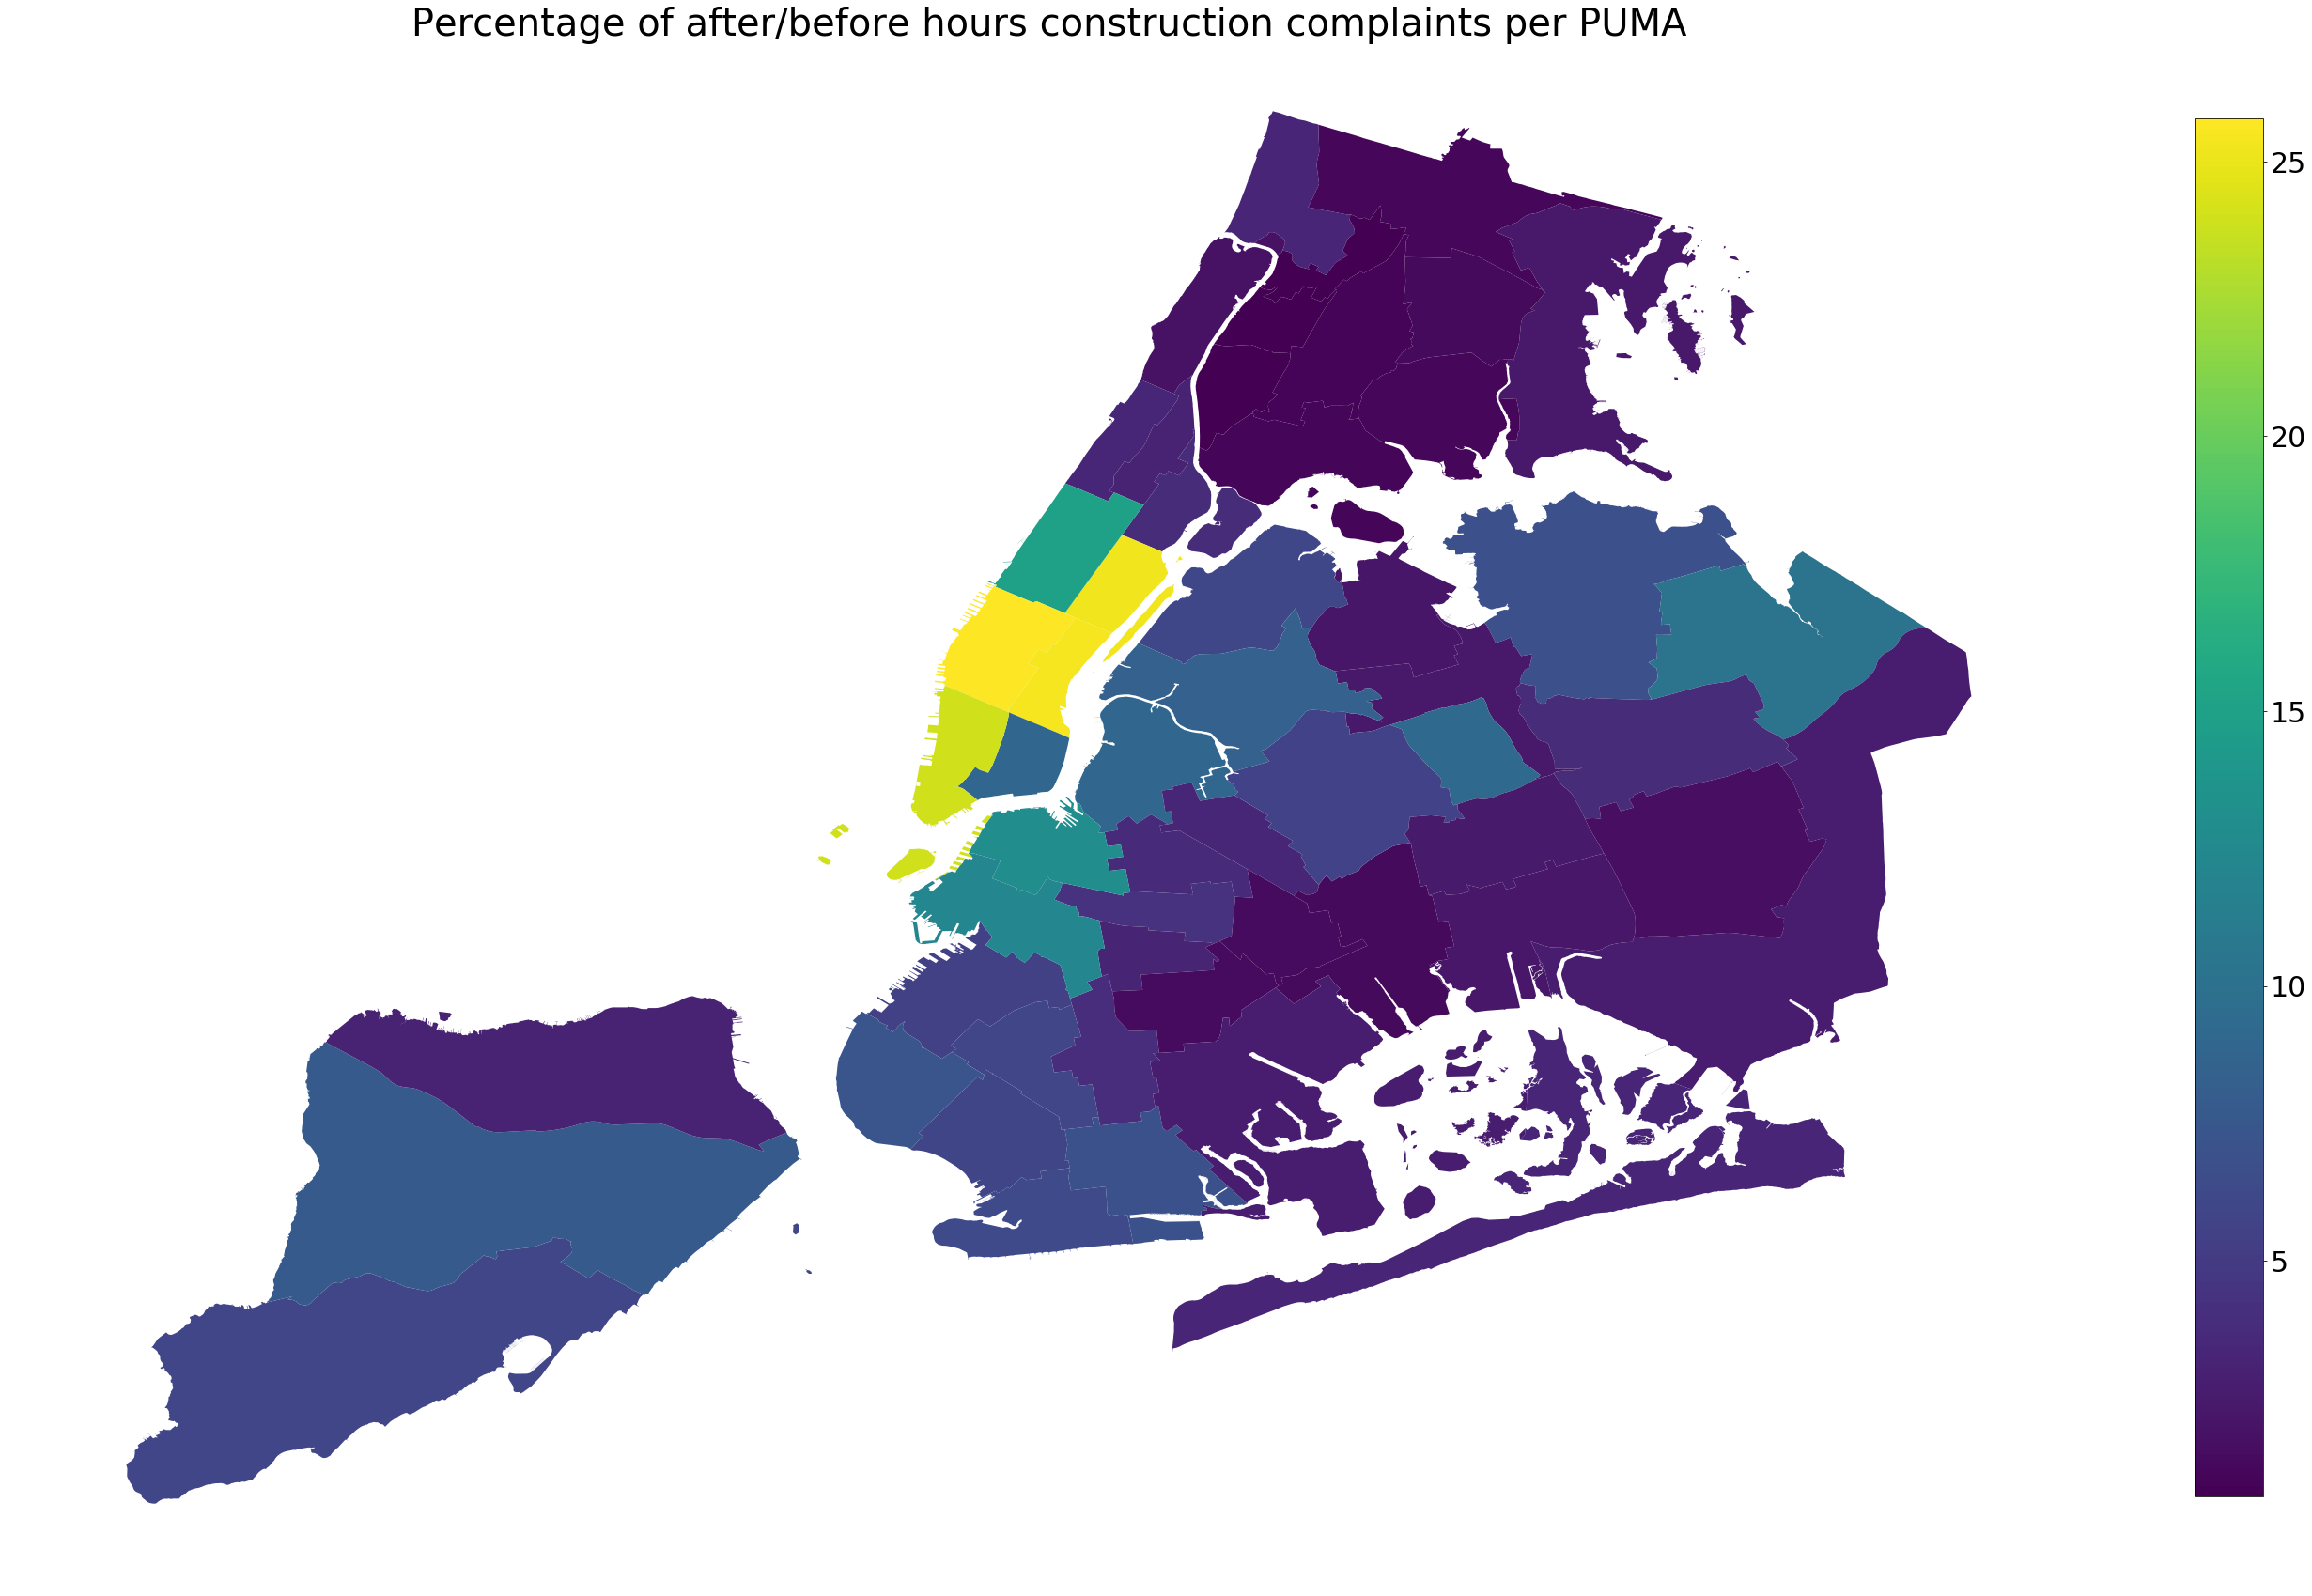

In [345]:
fig = pl.figure(figsize=(50,30))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('viridis')

houses_complaints_shp.plot(column='percentage after hours construction complaints', ax=ax, cmap=cmap)
sm = pl.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(houses_complaints_shp['percentage after hours construction complaints']),vmax=max(houses_complaints_shp['percentage after hours construction complaints'])), cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, orientation='vertical',shrink=0.9)
cbar.ax.tick_params(labelsize=30)
ax.set_title('Percentage of after/before hours construction complaints per PUMA', fontsize=40)
ax.axis('off')

#### Figure 1. Percentage of after/before hours construction complaints per PUMA. As we can see, areas in Manhattan are the ones where the percentage of noise complaints for after/before hours construction compared to all noise complaints in the area are much higher, followed by 4-5 areas between Brooklyn and Queens.

## 2.2. Plot percentage of houses in price category by PUMA

(-74.28337047742478, -73.67222994894009, 40.47514452607718, 40.93650364609647)

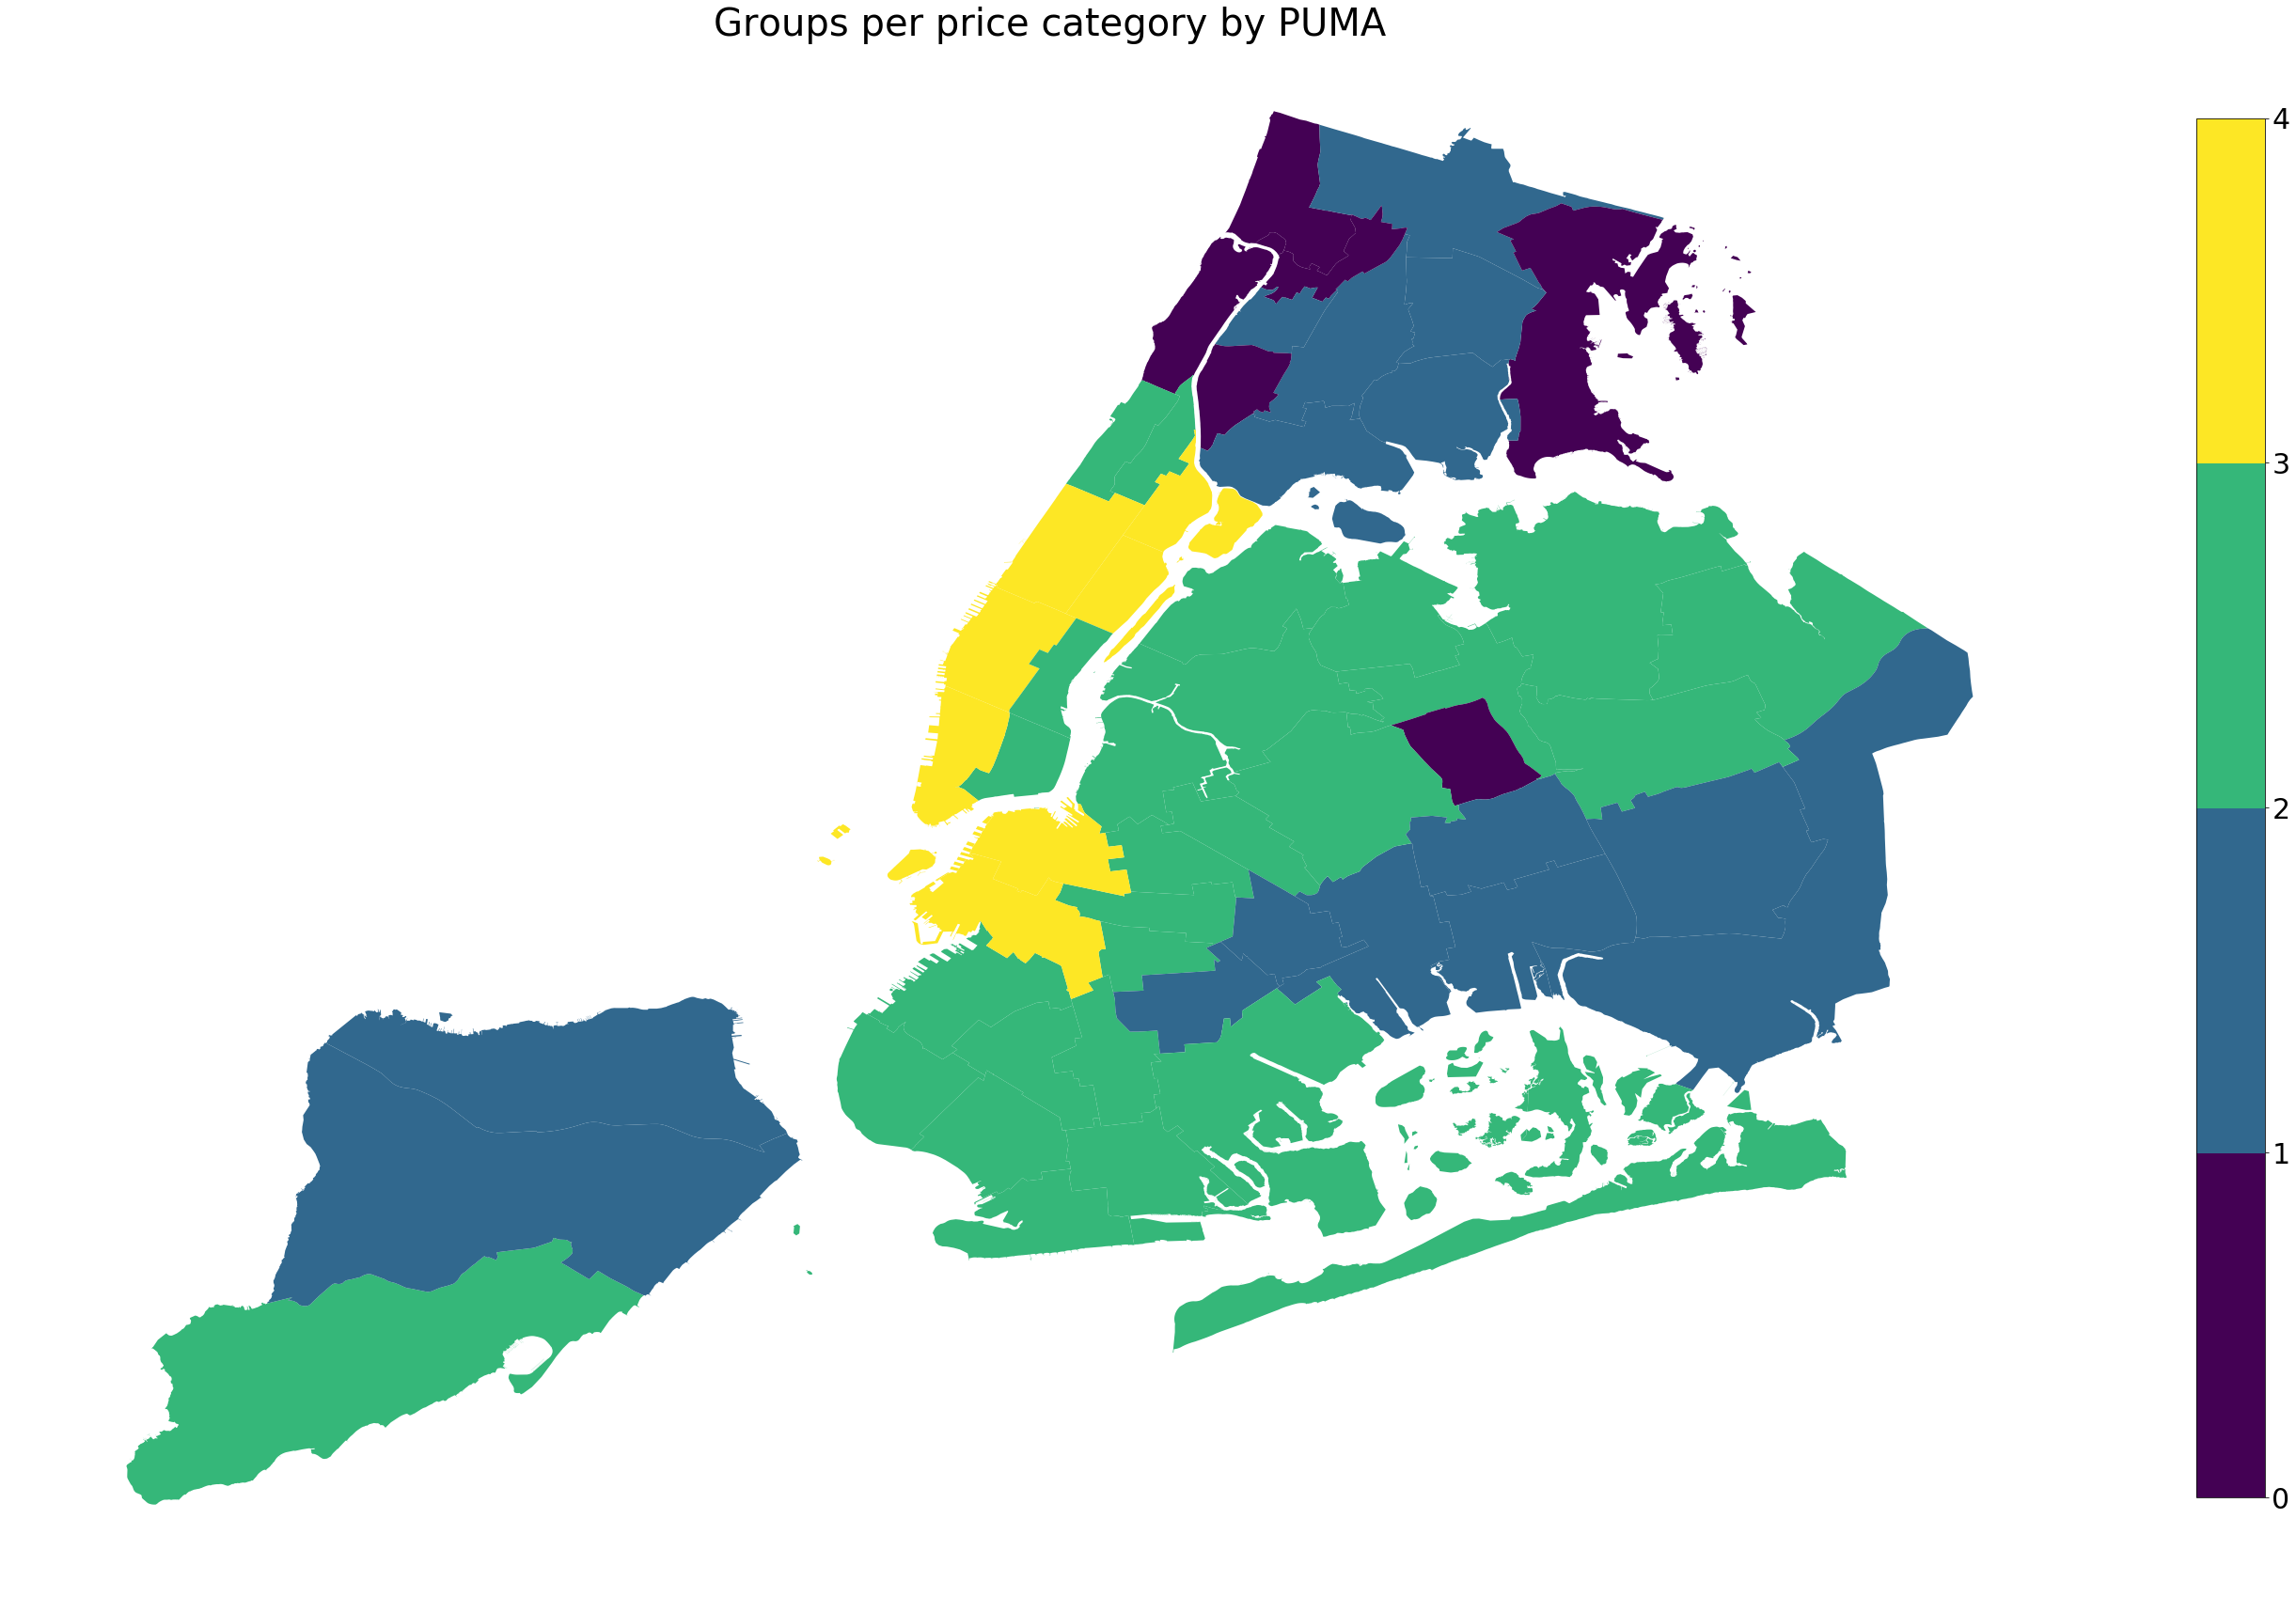

In [346]:
nc = max(houses_complaints_shp['group'])+1
fig = pl.figure(figsize=(50,30))
ax = fig.add_subplot(111)
cmap = plt.get_cmap('viridis', nc)

houses_complaints_shp.plot(column='group', ax=ax, cmap=cmap)
sm = pl.cm.ScalarMappable(norm=matplotlib.colors.BoundaryNorm(np.arange(0,nc+1), cmap.N), cmap=cmap)
sm._A = []
cbar = fig.colorbar(sm, orientation='vertical',shrink=0.9)
cbar.ax.tick_params(labelsize=30)
ax.set_title('Groups per price category by PUMA', fontsize=40)
ax.axis('off')

#### Figure 2. Groups per housing price category by PUMA. As we can see, the most expensive areas are in Manhattan, with one exception in Brooklyn, followed by most of Brooklyn and Queens and Staten Island, then by the rest of Brooklyn, Queens and Staten Island and finally, the Bronx.

## 2.3. Research question:

### Based on conversations with DEP, we believe that house owners of more expensive neighborhoods submit more complaints than those from less expensive neighborhoods. Our question then is: do owners of more expensive neighborhoods submit more complaints to 311 than those from less expensive neighborhoods?

First, we figure out if there is a correlation between the housing prices and the percentage of noise complaints from after/before hours construction

In [347]:
scipy.stats.pearsonr(houses_complaints_shp.group, houses_complaints_shp['percentage after hours construction complaints'])

(0.5984087102294081, 1.3982352624367965e-06)

According to Cohen (1988) strong, moderate and weak correlations are considered:<br><br>
Strong if $r \pm 0.5$<br>
Moderate if $r \pm 0.3$<br>
Weak if $r \pm 0.1$<br><br>
**Conclusion:** based on this, we can say that there is a strong positive relation between house prices and the percentage of noise complaints from after/before hours construction, which corresponds to our original thoughts.

## 2.4. Null Hypothesis:

The null hypothesis is that the mean percentage of noise complaints from all housing price groups are the same<br><br>

$H_0: \%after\_hour\_CC_0 = \%after\_hour\_CC_1 = \%after\_hour\_CC_2 = \%after\_hour\_CC_3$ <br><br>

The alternative hypothesis is that the mean percentage of noise complaints from all housing price groups are not the same.<br><br>

We set our alpha value at $\alpha = 0.05$

In [348]:
alpha = 0.05

In [349]:
p = scipy.stats.f_oneway(houses_complaints_shp[houses_complaints_shp.group == 0]\
                         ['percentage after hours construction complaints'].values, 
                         houses_complaints_shp[houses_complaints_shp.group == 0]\
                         ['percentage after hours construction complaints'].values,
                         houses_complaints_shp[houses_complaints_shp.group == 1]\
                         ['percentage after hours construction complaints'].values,
                         houses_complaints_shp[houses_complaints_shp.group == 2]\
                         ['percentage after hours construction complaints'].values, 
                         houses_complaints_shp[houses_complaints_shp.group == 3]\
                         ['percentage after hours construction complaints'].values)[1]

if p > alpha:
    print('The null hypothesis that the mean percentage of noise complaints from all housing price groups are ' 
          'the same cannot be rejected')
else: 
    print('We reject the null hypothesis that the mean percentage of noise complaints from all housing price '
          'groups are the same at a p-value of', alpha)

We reject the null hypothesis that the mean percentage of noise complaints from all housing price groups are the same at a p-value of 0.05


## 2.5. Linear regression model

In [350]:
X = houses_complaints_shp['percentage after hours construction complaints']
X = smm.add_constant(X)
y = houses_complaints_shp['group']

In [351]:
model = smf.OLS(y, X).fit()
predictions = model.predict(X)

In [352]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  group   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     29.57
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           1.40e-06
Time:                        23:27:44   Log-Likelihood:                -56.204
No. Observations:                  55   AIC:                             116.4
Df Residuals:                      53   BIC:                             120.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              1.1526      0.128      8.989      0.000       0.895       1.410
percentage after hours construction complaints     0.0803      0.015      5.438      0.000       0.051       0.110
==============================================================================
Omnibus:                        6.128   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.047   Jarque-Bera (JB):                5.272
Skew:                          -0.734   Prob(JB):                       0.0716
Kurtosis:                       3.381   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model explains 36% of the of the variance in the variable group, which is the dependent variable. This could mean that we need more variables to explain better the model.